# Fitting an RNN model

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In this model I'm going to ignore the 'toxicity type' distinctions and instead reduce them to a single score from 0 to 6: 

In [2]:
from helpers import process
from collections import Counter

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['proc_text'] = [process(s) for s in train['comment_text']]
test['proc_text'] = [process(s) for s in test['comment_text']]
                
train['score'] = train['toxic'] \
                + train['severe_toxic'] \
                + train['threat'] \
                + train['insult'] \
                + train['obscene'] \
                + train['identity_hate']
Counter(train['score'])

Counter({0: 143346, 1: 6360, 2: 3480, 3: 4209, 4: 1760, 5: 385, 6: 31})

In [3]:
y = train['score'].values
list_sentences_train = train["proc_text"]
list_sentences_test = test["proc_text"]

The following tokenises and indexes input text:

In [4]:
max_features = 10000
filters = '"#$%&()*+,-./:;<=>@[\\]^`{|}~\t\n' # keep '!?_'

tokenizer = Tokenizer(num_words=max_features, filters=filters) 

tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

For example:

In [5]:
from keras.preprocessing.text import text_to_word_sequence

filters = '"#$%&()*+,-./:;<=>@[\\]^`{|}~\t\n'

for x in list_sentences_train[:2]:
    print(x)
    print(text_to_word_sequence(x, filters=filters))
    print(tokenizer.texts_to_sequences([x]))
    print("")

explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls __CAPS__ fac and please dont remove the template from the talk page since im retired __IP__
['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'werent', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', '__caps__', 'fac', 'and', 'please', 'dont', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'im', 'retired', '__ip__']
[[650, 79, 1, 126, 130, 178, 31, 636, 4214, 1042, 86, 322, 55, 2074, 54, 6521, 17, 64, 2580, 149, 7, 2772, 37, 117, 1155, 8, 2794, 4, 48, 57, 241, 1, 423, 33, 1, 47, 30, 145, 72, 3275, 112]]

daww __!!!__ he matches this background colour im seemingly stuck with thanks talk __NUM__ january __NUM__ __NUM__ utc
['daww', '__!!!__', 'he', 'matches', 'th

Back to the modelling:

In [6]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Build model architecture: 

input --> 128-dim embedding --> 64 LSTMs --> 32-dim dense --> 1-dim ReLu score

In [8]:
nh = [128, 64, 32]
embed_size = nh[0]

inp = Input(shape=(maxlen, )) # maxlen=200 as defined earlier
x = Embedding(max_features, embed_size)(inp)
x = LSTM(nh[1], return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(nh[2], activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="relu")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='img/model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 64)           49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

... and fit model:

In [ ]:
from keras.callbacks import Callback

batch_size = 32
epochs = 4

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

model.fit(X_t, y, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=0,
          validation_split=0.1, 
          callbacks=[history])

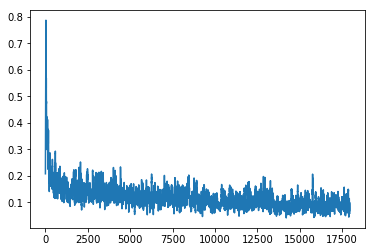

In [11]:
# show the SGD progress:
def movingaverage(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

plt.plot(movingaverage(history.losses, 20))
plt.show()

In [17]:
fn = "model_%d_%d_%d_1_wts.npz" % (nh[0], nh[1], nh[2])

wts = model.get_weights()
np.savez("models/%s" % fn, wts=wts)

In [12]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

test['score'] = y_test

153164/153164 [==============================] - 212s 1ms/step

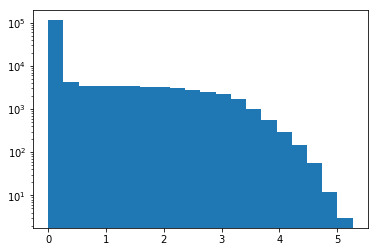

In [13]:
plt.hist(y_test, bins=20)
plt.yscale('log')
plt.show()

In [16]:
from random import sample

smin = 1
smax = 6
ssize = 10

df = test[(smin <= test.score) & (test.score < smax)].sample(ssize).sort_values(by='score')

for index, row in df.iterrows():
    print row['score']
    print row['comment_text']
    print("")

1.24273586273
:OK, that does it; that (comment above) is reason enough to remove the reference and remove it every fucking time it appears in this article!  a Jew, February 25, 2006

1.50101685524
Also lil Wayne at the age of 6 says he is a bitch

1.56100463867
" 

 == Seth MacFarlane's criticisms == 

 Should Seth MacFarlane's criticisms be quoted in whole, in part or not at all? In ""The Advocate"" he said about the PTC criticisms of him: 

 ""Oh, yeah. That’s like getting hate mail from Hitler. They’re literally terrible human beings. I’ve read their newsletter, I’ve visited their website, and they’re just rotten to the core. For an organization that prides itself on Christian values—I mean, I’m an atheist, so what do I know?—they spend their entire day hating people. They can all suck my dick as far as I’m concerned."" 

 I think the comments have some bearing on the article due to the relationship the PTC established with MacFarlane (with their criticisms)  but what I'm unsure. Th